This notebook is used to analyze the generated and prepared data.

# Preprocessed Data

### Tokenizer

In [20]:
import os
import json
from tqdm import tqdm
from collections import Counter
from mmassist.model.tokenization_proact import build_tokenizer_and_update_config
from mmassist.model.configuration_proact import ProActLlamaConfig

config = ProActLlamaConfig(
    img_token="<image>",
    img_sep_token="EOS",
    img_patch_token_size=0,
    max_seq_len=8192,
    padding_side="right",
)
tokenizer = build_tokenizer_and_update_config(config)
chat_formatter = tokenizer.chat_formatter

In [9]:
texts  = ["ths is", "sequence 2 xxxfe fo of alkfdj"]
out = tokenizer(texts,return_offsets_mapping=True,
            add_special_tokens=False,
            return_tensors="pt",
            padding=True,
            truncation=False,  # truncate in model's forward method
        )
out.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping'])

In [22]:
config = ProActLlamaConfig.from_pretrained_llama("meta-llama/Meta-Llama-3.1-8B-Instruct")

### Dialog

In [12]:
import os
import json
from tqdm import tqdm
import datasets as hf_datasets


data_root_dir = "/fsx_0/user/imzyc/processed_data/"
datasets = ["ego4d", "holoassist", "egoexolearn", "epickitchens", "wtag", "assembly101"]

filtered = True
if filtered:
    splits = ["train", "val", "test"]
    suffix = "_filtered"
else:
    splits = ["train", "val"]
    suffix = ""

all_videos_by_split = {}
existed_video_uids = {}
all_conversations = []
for split in splits:
    for dataset in datasets:
        # print(f"Dataset: {dataset}")
        dialogs = []
        videos_by_split = []

        ### load seperately
        # dialog_data_dir = os.path.join(data_root_dir, dataset, f"generated_dialogs/{split}")
        # for dialog_file in tqdm(os.listdir(dialog_data_dir)):
        #     with open(os.path.join(dialog_data_dir, dialog_file), "r") as f:
        #         dialog = json.load(f)
        #     if 'reason_to_exclude' not in dialog:
        #         dialogs.append(dialog)
        #         videos_by_split.append(dialog)

        ### load all
        data_file = os.path.join(data_root_dir, dataset, f"generated_dialogs/{split}{suffix}.json")
        with open(data_file, "r") as f:
            videos_by_split = json.load(f)
        
        for v in videos_by_split:
            all_conversations.extend(v["conversations"])
        
        print(f"Dataset: {dataset} Split: {split} loaded")
        all_videos_by_split[f"{dataset}-{split}"] = videos_by_split

Dataset: ego4d Split: train loaded
Dataset: holoassist Split: train loaded
Dataset: egoexolearn Split: train loaded
Dataset: epickitchens Split: train loaded
Dataset: wtag Split: train loaded
Dataset: assembly101 Split: train loaded
Dataset: ego4d Split: val loaded
Dataset: holoassist Split: val loaded
Dataset: egoexolearn Split: val loaded
Dataset: epickitchens Split: val loaded
Dataset: wtag Split: val loaded
Dataset: assembly101 Split: val loaded
Dataset: ego4d Split: test loaded
Dataset: holoassist Split: test loaded
Dataset: egoexolearn Split: test loaded
Dataset: epickitchens Split: test loaded
Dataset: wtag Split: test loaded
Dataset: assembly101 Split: test loaded


In [13]:
from collections import Counter
domains = {"all_by_video_cnt": Counter(), "all_by_duration": Counter()}
total_video_cnt = {k: 0 for k in splits + ["all"]}
total_conv_cnt = {k: 0 for k in splits + ["all"]}
total_duration = {k: 0 for k in splits + ["all"]}

if filtered:
    print("Data statistics after filtering:")
else:
    print("Data statistics before filtering:")

for split in splits:
    print("*"*30, f"[{split}]", "*"*30)
    for dataset in datasets:
        cnt = 0
        num_convs = 0
        duration = 0
        key = f"{dataset}-{split}"
        domains[key] =  Counter()
        for d in all_videos_by_split[key]:
            dom = d['parsed_video_anns']["domain"]
            domains[key][dom] += 1
            domains["all_by_video_cnt"][dom] += 1
            domains["all_by_duration"][dom] += d['parsed_video_anns']["duration"]
            cnt += 1
            duration += d['parsed_video_anns']["duration"]
            num_convs += len(d['conversations'])
            total_video_cnt[split] += 1
            total_video_cnt["all"] += 1
            total_duration[split] += d['parsed_video_anns']["duration"]
            total_duration["all"] += d['parsed_video_anns']["duration"]
            total_conv_cnt[split] += len(d['conversations'])
            total_conv_cnt["all"] += len(d['conversations'])

        print(f"{dataset:15} | #videos: {cnt:5} | duration: {duration/3600:5.1f}h | #convs: {num_convs:5}")

    print("-"*13)
    total_hours = total_duration[split] / 3600
    total_num_convs = total_conv_cnt[split]
    print(f"Total {' ':9} | #videos {total_video_cnt[split]:6} | duration: {total_hours:5.1f}h | #convs: {total_num_convs:5}")

total_hours = total_duration["all"] / 3600
print("\n" + "*"*31, "ALL", "*"*31)
print(f"Total {' ':9} | #videos {total_video_cnt['all']:6} | duration: {total_hours:5.1f}h | #convs: {total_conv_cnt['all']:5}")

Data statistics after filtering:
****************************** [train] ******************************
ego4d           | #videos:   382 | duration: 136.6h | #convs:  3182
holoassist      | #videos:  1436 | duration: 107.0h | #convs:  7052
egoexolearn     | #videos:   321 | duration:  68.5h | #convs:  3210
epickitchens    | #videos:   320 | duration:  34.0h | #convs:  6376
wtag            | #videos:    40 | duration:   7.1h | #convs:   786
assembly101     | #videos:   756 | duration:  43.1h | #convs:  7492
-------------
Total           | #videos   3255 | duration: 396.3h | #convs: 28098
****************************** [val] ******************************
ego4d           | #videos:    32 | duration:  11.6h | #convs:    96
holoassist      | #videos:    97 | duration:   7.6h | #convs:   291
egoexolearn     | #videos:    41 | duration:   8.8h | #convs:   123
epickitchens    | #videos:    50 | duration:   4.2h | #convs:   150
wtag            | #videos:     7 | duration:   1.2h | #convs:    21

In [157]:
# pass

Data statistics before filtering:
****************************** [train] ******************************
ego4d           | #videos:   443 | duration: 157.6h | #convs:  4421
holoassist      | #videos:  1464 | duration: 109.0h | #convs: 14640
egoexolearn     | #videos:   321 | duration:  68.5h | #convs:  3210
epickitchens    | #videos:   320 | duration:  34.0h | #convs:  3199
wtag            | #videos:    40 | duration:   7.1h | #convs:   400
assembly101     | #videos:   756 | duration:  43.1h | #convs:  7560
-------------
Total           | #videos   3344 | duration: 419.4h | #convs: 33430
****************************** [val] ******************************
ego4d           | #videos:    99 | duration:  41.6h | #convs:   990
holoassist      | #videos:   207 | duration:  15.6h | #convs:  2070
egoexolearn     | #videos:    82 | duration:  18.2h | #convs:   820
epickitchens    | #videos:   100 | duration:   8.2h | #convs:  1000
wtag            | #videos:    14 | duration:   2.5h | #convs:   14

### Plot dialog turn length distributions

In [ ]:
from tqdm import tqdm

length_user_turns = []
length_assistant_turns = []
length_summaries = []

num_turns = []

for c in tqdm(all_conversations):
    for turn in c["conversation"]:
        if turn["role"] == "user":
            length_user_turns.append(len(turn["content"].split()))
        elif turn["role"] == "assistant":
            length_assistant_turns.append(len(turn["content"].split()))
            if "progress" in turn:
                length_summaries.append(len(turn["progress"].split()))

Average turn length: 13.89 words


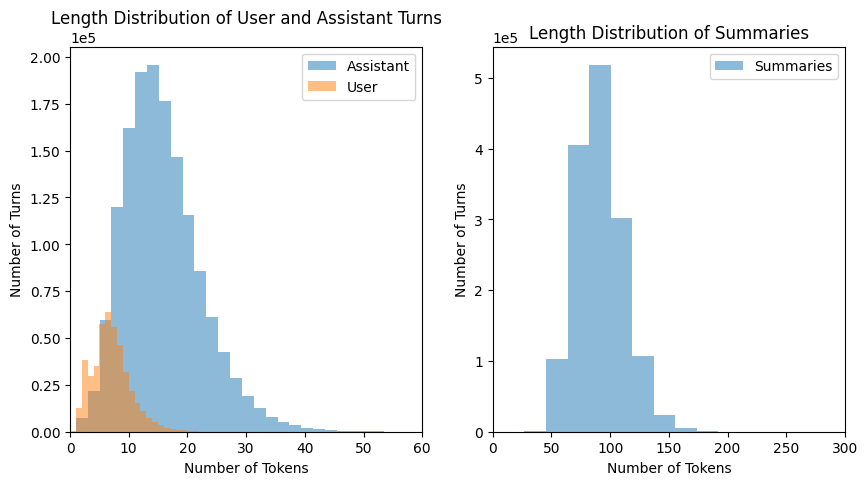

In [113]:
# plot the length distributions of the generated conversations
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot the length distributions of the user and assistant turns
ax[0].hist(length_assistant_turns, bins=50, alpha=0.5, label="Assistant")
ax[0].hist(length_user_turns, bins=50, alpha=0.5, label="User")
ax[0].set_title("Length Distribution of User and Assistant Turns")
ax[0].set_xlabel("Number of Tokens")
ax[0].set_ylabel("Number of Turns")
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].set_xlim(0, 60)
ax[0].legend()

# plot the length distributions of the summaries
ax[1].hist(length_summaries, bins=50, alpha=0.5, label="Summaries")
ax[1].set_title("Length Distribution of Summaries")
ax[1].set_xlabel("Number of Tokens")
ax[1].set_ylabel("Number of Turns")
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# x range
ax[1].set_xlim(0, 300)
ax[1].legend()

avg_turn_length = sum(length_user_turns + length_assistant_turns) / len(length_user_turns + length_assistant_turns)
print(f"Average turn length: {avg_turn_length:.2f} words")

ego4d
holoassist
egoexolearn
epickitchens
wtag
assembly101


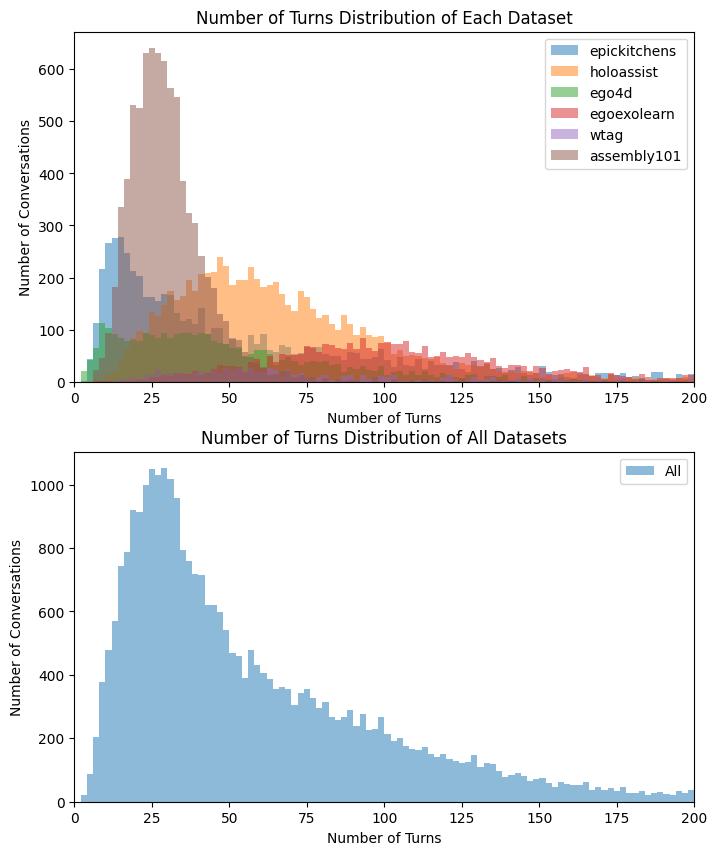

In [112]:
num_turns_per_dataset = {"all": []}
for dataset in datasets:
    print(dataset)
    num_turns_per_dataset[dataset] = []
    for split in splits:
        key = f"{dataset}-{split}"
        for video in all_videos_by_split[key]:
            for conv in video["conversations"]:
                num_turns_per_dataset[dataset].append(len(conv["conversation"]))
                num_turns_per_dataset["all"].append(len(conv["conversation"]))
cutoff = 200
# plot the num turn distributions of each dataset
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
for dataset in [
    "epickitchens",
    "holoassist",
    "ego4d",
    "egoexolearn",
    "wtag",
    "assembly101",
]:
    ax[0].hist(
        num_turns_per_dataset[dataset],
        bins=100,
        alpha=0.5,
        label=dataset,
        range=(0, cutoff),
    )
ax[0].set_title("Number of Turns Distribution of Each Dataset")
ax[0].set_xlabel("Number of Turns")
ax[0].set_ylabel("Number of Conversations")
ax[0].set_xlim(0, cutoff)
ax[0].legend()

# plot the num turn distributions of all datasets
ax[1].hist(
    num_turns_per_dataset["all"], bins=100, alpha=0.5, label="All", range=(0, cutoff)
)
ax[1].set_title("Number of Turns Distribution of All Datasets")
ax[1].set_xlabel("Number of Turns")
ax[1].set_ylabel("Number of Conversations")
ax[1].set_xlim(0, cutoff)
ax[1].legend()



### Utterance Distributions

In [138]:
from collections import Counter

total_duration = 0
turn_lengths = []

counter_groups = ["Assistant Initiativity", "Assistant Intent"]
user_types = ["no_talk", "talk_some", "talk_more"]
all_counters = {}
for group in counter_groups:
    all_counters[group] = {k: Counter() for k in user_types}

for sample in tqdm(all_conversations):
    user_type = sample['user_type']
    conversation = sample["conversation"]
    for turn in conversation:
        role = turn["role"]
        # all_counters["Role of Turn"][user_type][role] += 1
        if role == "assistant":
            labels = turn["labels"]
            initiativity, intents = labels.split("|")
            intents = intents.split(",")
            all_counters["Assistant Initiativity"][user_type][initiativity] += 1
            for intent in intents:
                all_counters["Assistant Intent"][user_type][intent] += 1
        
        if role in ["assistant", "user"]:
            turn_lengths.append(len(turn["content"].split()))


100%|██████████| 30135/30135 [00:02<00:00, 10962.47it/s]


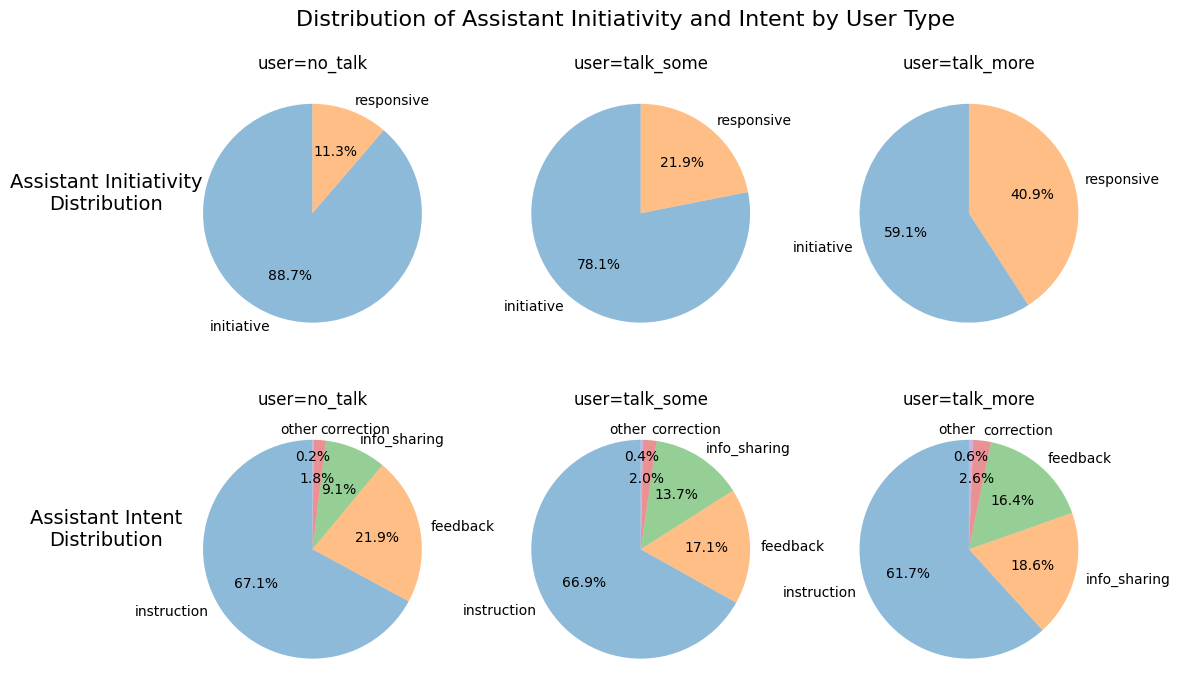

In [144]:
# draw pie chart
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle(
    "Distribution of Assistant Initiativity and Intent by User Type",
    fontsize=16,
    y=0.96,
)

for i, group in enumerate(counter_groups):
    for j, user_type in enumerate(user_types):
        ax = axs[i, j]
        counter = all_counters[group][user_type]
        counter = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
        patches, texts, autotexts = ax.pie(
            counter.values(),
            labels=counter.keys(),
            autopct="%1.1f%%",
            startangle=90,
            radius=1,
            wedgeprops={"alpha": 0.5}
        )

        for t, l in zip(texts, autotexts):
            if t._text == "other":
                t._x -= 0.3
                l._y += 0.25
            if t._text == "correction":
                l._y += 0.05

        ax.set_title(f"user={user_type}")

        if j == 0:
            ax.set_ylabel(
                f"{group}\nDistribution", rotation=0, labelpad=50, fontsize=14
            )

In [88]:
from collections import Counter

total_duration = 0
turn_lengths = []

counter_groups = ["Role of Turn", "Assistant Initiativity", "Assistant Intent", "Talk or Not"]
user_types = ["no_talk", "talk_some", "talk_more"]
all_counters = {}
for group in counter_groups:
    all_counters[group] = {k: Counter() for k in user_types}

for sample in tqdm(data):
    user_type = sample['user_type']
    conversation = sample["conversation"]
    fps = sample['sample_fps']
    total_duration += (sample['end_frame_idx'] - sample['start_frame_idx']) / fps
    for turn in conversation:
        role = turn["role"]
        if role != "frames":
            all_counters["Role of Turn"][user_type][role] += 1
            if role == "assistant":
                labels = turn["labels"]
                initiativity, intents = labels.split("|")
                intents = intents.split(",")
                all_counters["Assistant Initiativity"][user_type][initiativity] += 1
                for intent in intents:
                    intent = "other" if intent == "mistake_correction" else intent
                    all_counters["Assistant Intent"][user_type][intent] += 1
            
            if role in ["assistant", "user"]:
                turn_lengths.append(len(turn["content"].split()))
        else:
            num_frames = turn["end"] - turn["start"]
            all_counters["Talk or Not"][user_type]["talk"] += 1
            all_counters["Talk or Not"][user_type]["not_talk"] += num_frames - 1

avg_turn_length = sum(turn_lengths) / len(turn_lengths)
print(f"Total duration: {total_duration/3600:.1f} hours")
print(f"Average turn length: {avg_turn_length:.1f} words")


  0%|          | 0/2613 [00:00<?, ?it/s]

100%|██████████| 2613/2613 [00:02<00:00, 1068.38it/s]

Total duration: 617.0 hours
Average turn length: 13.7 words


### Domain Distribution

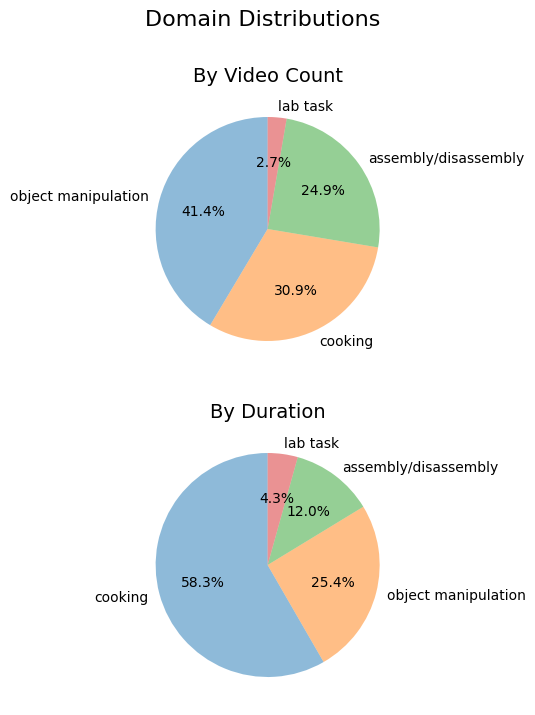

In [14]:
# draw pie chart for domain distribution
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(4, 8))
fig.suptitle(f"Domain Distributions", fontsize=16)

key_to_name = {
    "all_by_video_cnt": "By Video Count",
    "all_by_duration": "By Duration",
}

for i, key in enumerate(["all_by_video_cnt", "all_by_duration"]):
    ax = axs[i]
    counter = domains[key]
    counter = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
    ax.pie(
        counter.values(),
        labels=counter.keys(),
        autopct="%1.1f%%",
        startangle=90,
        radius=1,
        wedgeprops={"alpha": 0.5},
    )
    ax.set_title(f"{key_to_name[key]}", fontsize=14)

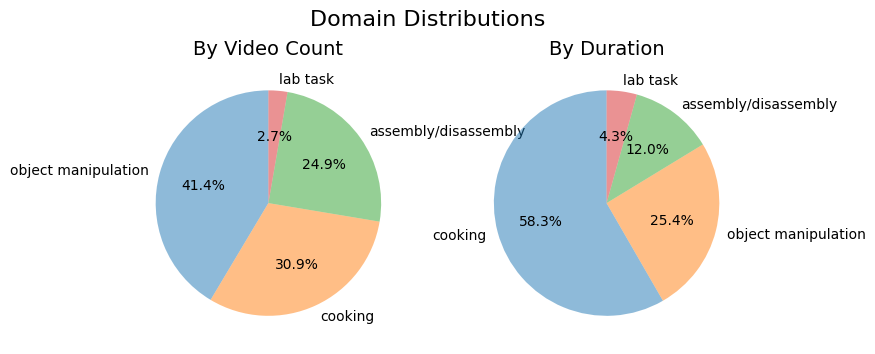

In [147]:
# draw pie chart for domain distribution
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(f"Domain Distributions", fontsize=16)

key_to_name = {
    "all_by_video_cnt": "By Video Count",
    "all_by_duration": "By Duration",
}

for i, key in enumerate(["all_by_video_cnt", "all_by_duration"]):
    ax = axs[i]
    counter = domains[key]
    counter = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
    ax.pie(
        counter.values(),
        labels=counter.keys(),
        autopct="%1.1f%%",
        startangle=90,
        radius=1,
        wedgeprops={"alpha": 0.5},
    )
    ax.set_title(f"{key_to_name[key]}", fontsize=14)

# Prepared Data

## Num Training Samples

In [13]:
import os
import datasets as hf_datasets
from tqdm import tqdm
from mmassist.data.utils import format_size

hf_datasets.disable_progress_bars()

data_dir = "/fsx_0/user/imzyc/processed_data/"

results = {}
prepared_datasets = {}

datasets = ["ego4d", "holoassist", "egoexolearn", "epickitchens", "wtag", "assembly101"]
split = "train"
L = [4096]
# L = [0]
I = [10] #, 5, 10, 26]
# L = [4096]
# I = [1]
# data_types = ["dialog-klg-sum"] #, "summary"]#, "dialog-sum"]
# data_types = ["summary"]
data_types = ["dialog-sum"]


for data_type in data_types:
    for dataset in  datasets:
        print(dataset)
        data_name = dataset #f"{dataset} {data_type}"
        results[data_name] = {}
        for l in L:
            for i in I:
                data_file = os.path.join(data_dir, dataset, f"prepared/{data_type}_{split}_L{l}_I{i}+SEP.jsonl")
                data = hf_datasets.Dataset.from_json(data_file)
                name = f"L={l} I={i}"
                results[data_name][name] = len(data)
                prepared_datasets[data_file] = data

s1_datasets = [
    "ego4d/narration_train",
    # "sthsthv2/narration_train",
    # "llava/caption_train",
    # "egoobjects/detection_train",
]
for dataset_full in s1_datasets:
    dataset, prefix = dataset_full.split("/")
    results[dataset] = {}
    for l in L:
        for i in I:
            data_file = os.path.join(data_dir, dataset, f"prepared/{prefix}_L{l}_I{i}.jsonl")
            data = hf_datasets.Dataset.from_json(data_file)
            name = f"L={l} I={i}"
            results[dataset][name] = len(data)
            prepared_datasets[data_file] = data



for k, v in results.items():
    names = list(v.keys())
    break

header = "\t" + "\t".join(names)
# print(header)
for k, v in results.items():
    # print(f"{k:45}", " ".join(names))
    row = k + "\t"
    all_nums = []
    for name, num in v.items():
        all_nums.append(str(num))
    row += "\t\t\t".join(all_nums)
    print(row)

ego4d
holoassist
egoexolearn
epickitchens
wtag
assembly101
ego4d	101672
holoassist	16473
egoexolearn	18826
epickitchens	19944
wtag	3439
assembly101	13270


In [10]:
import numpy as np

for data_name, samples in prepared_datasets.items():
    print(data_name)
    assistant_turn_intervals = []
    for sample in samples:
        last_ass_time = sample['start_frame_idx'] / 2
        last_turn = None
        for turn in sample["conversation"]:
            if turn["role"] == "assistant":
                curr_time = None
                if turn.get("time") is not None:
                    curr_time = turn["time"]
                elif last_turn is not None and last_turn["end"] is not None:
                    curr_time = last_turn["end"] / 2
                if curr_time is not None:
                    assistant_turn_intervals.append(curr_time - last_ass_time)
                    last_ass_time = curr_time
            last_turn = turn
    print(f"Mean interval: {np.mean(assistant_turn_intervals):.2f}s")


/fsx_0/user/imzyc/processed_data/ego4d/prepared/dialog_val_L0_I10+SEP.jsonl
Mean interval: 23.10s
/fsx_0/user/imzyc/processed_data/holoassist/prepared/dialog_val_L0_I10+SEP.jsonl
Mean interval: 5.25s
/fsx_0/user/imzyc/processed_data/egoexolearn/prepared/dialog_val_L0_I10+SEP.jsonl
Mean interval: 7.95s
/fsx_0/user/imzyc/processed_data/epickitchens/prepared/dialog_val_L0_I10+SEP.jsonl
Mean interval: 6.78s
/fsx_0/user/imzyc/processed_data/wtag/prepared/dialog_val_L0_I10+SEP.jsonl
Mean interval: 11.67s
/fsx_0/user/imzyc/processed_data/assembly101/prepared/dialog_val_L0_I10+SEP.jsonl
Mean interval: 8.77s
/fsx_0/user/imzyc/processed_data/ego4d/prepared/narration_train_L4096_I10.jsonl
Mean interval: 5.09s


In [74]:

for data_name, samples in prepared_datasets.items():
    print(data_name)
    seq_lens = []
    num_talk = 0
    num_not_talk = 0
    for sample in samples:
        seq_lens.append(sample["seq_len"])
    seq_lens.sort(reverse=True)
    print(seq_lens[:20])

/fsx_0/user/imzyc/processed_data/ego4d/prepared/summary_train_L4096_I10+SEP.jsonl
[4013, 4002, 4000, 3993, 3984, 3976, 3976, 3970, 3969, 3965, 3963, 3963, 3963, 3961, 3951, 3948, 3944, 3944, 3943, 3943]
/fsx_0/user/imzyc/processed_data/holoassist/prepared/summary_train_L4096_I10+SEP.jsonl
[3918, 3914, 3911, 3907, 3890, 3889, 3885, 3872, 3870, 3867, 3867, 3866, 3866, 3863, 3861, 3856, 3846, 3846, 3846, 3838]
/fsx_0/user/imzyc/processed_data/egoexolearn/prepared/summary_train_L4096_I10+SEP.jsonl
[3956, 3910, 3884, 3882, 3873, 3870, 3860, 3857, 3854, 3854, 3850, 3848, 3846, 3846, 3846, 3844, 3842, 3840, 3839, 3837]
/fsx_0/user/imzyc/processed_data/epickitchens/prepared/summary_train_L4096_I10+SEP.jsonl
[3961, 3930, 3845, 3839, 3838, 3832, 3828, 3821, 3821, 3815, 3813, 3812, 3809, 3808, 3808, 3802, 3802, 3802, 3800, 3797]
/fsx_0/user/imzyc/processed_data/wtag/prepared/summary_train_L4096_I10+SEP.jsonl
[3971, 3956, 3908, 3898, 3890, 3870, 3870, 3869, 3869, 3867, 3863, 3862, 3862, 3861, 3861

In [32]:

for data_name, samples in prepared_datasets.items():
    print(data_name)
    seq_lens = []
    num_talk = 0
    num_not_talk = 0
    for sample in samples:
        seq_lens.append(sample["seq_len"])
    seq_lens.sort(reverse=True)
    print(seq_lens[:10])

/fsx_0/user/imzyc/processed_data/ego4d/prepared/dialog-klg-sum_train_L4096_I10+SEP.jsonl
[4090, 4090, 4089, 4089, 4087, 4087, 4087, 4087, 4087, 4086]
/fsx_0/user/imzyc/processed_data/holoassist/prepared/dialog-klg-sum_train_L4096_I10+SEP.jsonl
[4090, 4090, 4089, 4089, 4088, 4087, 4086, 4086, 4085, 4085]
/fsx_0/user/imzyc/processed_data/egoexolearn/prepared/dialog-klg-sum_train_L4096_I10+SEP.jsonl
[4090, 4090, 4089, 4089, 4088, 4087, 4087, 4086, 4086, 4086]
/fsx_0/user/imzyc/processed_data/epickitchens/prepared/dialog-klg-sum_train_L4096_I10+SEP.jsonl
[4088, 4088, 4088, 4088, 4088, 4087, 4087, 4087, 4086, 4086]
/fsx_0/user/imzyc/processed_data/wtag/prepared/dialog-klg-sum_train_L4096_I10+SEP.jsonl
[4085, 4085, 4082, 4079, 4078, 4078, 4077, 4074, 4073, 4072]
/fsx_0/user/imzyc/processed_data/assembly101/prepared/dialog-klg-sum_train_L4096_I10+SEP.jsonl
[4090, 4090, 4090, 4090, 4090, 4090, 4089, 4089, 4088, 4088]


In [25]:
for data_name, samples in prepared_datasets.items():
    print(data_name)
    num_talk = 0
    num_not_talk = 0
    for sample in samples:
        for turn in sample["conversation"]:
            if turn["role"] == "frames":
                num_talk += 1
                num_not_talk += turn["end"] - turn["start"] - 1
    print(f"talk: {num_talk}, not talk: {num_not_talk}, ratio: {num_talk / (num_talk + num_not_talk):.2f}")

/fsx_0/user/imzyc/processed_data/ego4d/prepared/dialog-klg-sum_train_L4096_I1+SEP.jsonl
talk: 174067, not talk: 6805005, ratio: 0.02
/fsx_0/user/imzyc/processed_data/ego4d/prepared/summary_train_L4096_I1+SEP.jsonl
talk: 43886, not talk: 6736873, ratio: 0.01
/fsx_0/user/imzyc/processed_data/holoassist/prepared/dialog-klg-sum_train_L4096_I1+SEP.jsonl
talk: 489061, not talk: 3144597, ratio: 0.13
/fsx_0/user/imzyc/processed_data/holoassist/prepared/summary_train_L4096_I1+SEP.jsonl
talk: 165978, not talk: 3465988, ratio: 0.05
/fsx_0/user/imzyc/processed_data/egoexolearn/prepared/dialog-klg-sum_train_L4096_I1+SEP.jsonl
talk: 398394, not talk: 4541005, ratio: 0.08
/fsx_0/user/imzyc/processed_data/egoexolearn/prepared/summary_train_L4096_I1+SEP.jsonl
talk: 79991, not talk: 4860499, ratio: 0.02
/fsx_0/user/imzyc/processed_data/epickitchens/prepared/dialog-klg-sum_train_L4096_I1+SEP.jsonl
talk: 475550, not talk: 4302606, ratio: 0.10
/fsx_0/user/imzyc/processed_data/epickitchens/prepared/summary_

In [1]:
import os
from mmassist.data.utils import load_jsonl_to_arrow
data_dir = "/fsx_0/user/imzyc/processed_data/"
split = "train"

dataset = ["ego4d"]
L = [2048, 4096, 8192]
I = [1, 5, 10, 26]

for df in [
    "narration_train_L2048_I1+SEP.jsonl",
    "narration_train_L2048_I5+SEP.jsonl",
    "narration_train_L2048_I10+SEP.jsonl",
    "narration_train_L4096_I1+SEP.jsonl",
    "narration_train_L4096_I5+SEP.jsonl",
    "narration_train_L4096_I10+SEP.jsonl",
    "narration_train_L8192_I1+SEP.jsonl",
    "narration_train_L8192_I5+SEP.jsonl",
    "narration_train_L8192_I10+SEP.jsonl",
    "livechat_train_L2048_I1+SEP.jsonl",
]:
    data_file = os.path.join(data_dir, "prepared", df)
    data = load_jsonl_to_arrow(data_file)
    print(f"Loaded {df} with {len(data)} rows")

/data/home/imzyc/miniconda3/envs/mm/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda-12.1'


Loaded narration_train_L2048_I1+SEP.jsonl with 65276 rows
Loaded narration_train_L2048_I5+SEP.jsonl with 128313 rows
Loaded narration_train_L2048_I10+SEP.jsonl with 198977 rows
Loaded narration_train_L4096_I1+SEP.jsonl with 37265 rows
Loaded narration_train_L4096_I5+SEP.jsonl with 71075 rows
Loaded narration_train_L4096_I10+SEP.jsonl with 109907 rows
Loaded narration_train_L8192_I1+SEP.jsonl with 23234 rows
Loaded narration_train_L8192_I5+SEP.jsonl with 40831 rows
Loaded narration_train_L8192_I10+SEP.jsonl with 61834 rows
Loaded livechat_train_L2048_I1+SEP.jsonl with 15206 rows
Loaded dialog_train_L2048_I1+SEP.jsonl with 6673 rows


In [2]:
import os
from mmassist.data.utils import load_jsonl_to_arrow
data_dir = "/fsx_0/user/imzyc/processed_data/ego4d"
for df in [
    "dialog_train_L2048_I1+SEP.jsonl",
    "dialog_train_L2048_I5+SEP.jsonl",
    "dialog_train_L2048_I10+SEP.jsonl",
    "dialog_train_L8192_I1+SEP.jsonl",
    "dialog_train_L8192_I5+SEP.jsonl",
    "dialog_train_L8192_I10+SEP.jsonl",
]:
    data_file = os.path.join(data_dir, "prepared", df)
    data = load_jsonl_to_arrow(data_file)
    print(f"Loaded {df} with {len(data)} rows")

Loaded dialog_train_L2048_I1+SEP.jsonl with 6673 rows
Loaded dialog_train_L2048_I5+SEP.jsonl with 13825 rows
Loaded dialog_train_L2048_I10+SEP.jsonl with 20916 rows
Loaded dialog_train_L8192_I1+SEP.jsonl with 2642 rows
Loaded dialog_train_L8192_I5+SEP.jsonl with 4662 rows
Loaded dialog_train_L8192_I10+SEP.jsonl with 6956 rows


In [1]:
import os
from mmassist.data.utils import load_jsonl_to_arrow
data_dir = "/fsx_0/user/imzyc/processed_data/llava"
for df in [
    "caption_L2048_I1.jsonl",
    "caption_L2048_I5.jsonl",
    "caption_L2048_I10.jsonl",
    "caption_L4096_I1.jsonl",
    "caption_L4096_I5.jsonl",
    "caption_L4096_I10.jsonl",
    "caption_L8192_I1.jsonl",
    "caption_L8192_I5.jsonl",
    "caption_L8192_I10.jsonl",
]:
    data_file = os.path.join(data_dir, "prepared", df)
    data = load_jsonl_to_arrow(data_file)
    print(f"Loaded {df} with {len(data)} rows")

/data/home/imzyc/miniconda3/envs/mm/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda-12.1'


Loaded caption_L2048_I1.jsonl with 5320 rows
Loaded caption_L2048_I5.jsonl with 6439 rows
Loaded caption_L2048_I10.jsonl with 7839 rows
Loaded caption_L4096_I1.jsonl with 2799 rows
Loaded caption_L4096_I5.jsonl with 3357 rows
Loaded caption_L4096_I10.jsonl with 3920 rows
Loaded caption_L8192_I1.jsonl with 1400 rows
Loaded caption_L8192_I5.jsonl with 1680 rows
Loaded caption_L8192_I10.jsonl with 1960 rows


## Ego4D

### Ego4D Narration

In [55]:
import os
import datasets as hf_datasets
from tqdm import tqdm
from mmassist.model.configuration_proact import ProActConfig
from mmassist.model.tokenization_proact import build_tokenizer_and_update_config, MultimodalChat
from mmassist.data.data_collator import ProActCollator


data_dir = "/fsx_0/user/imzyc/processed_data/ego4d"
for L in [8192]:
    for I in [10]:
        df = f"narration_train_L{L}_I{I}+SEP.jsonl"
        data_file = os.path.join(data_dir, "prepared", df)
        data = hf_datasets.Dataset.from_json(data_file)
        print(f"Loaded {df} with {len(data)} rows")

        config = ProActConfig(
            img_patch_token_size= int((I - 1) ** 0.5),
            use_img_cls_token=True,
            img_sep_token="<|eot_id|>"
        )
        tokenizer = build_tokenizer_and_update_config(config)
        chat_formatter = tokenizer.chat_formatter
        collator = ProActCollator(tokenizer, chat_formatter)

        all_num_tokens = 0
        all_num_img_tokens = 0
        all_num_txt_tokens = 0
        all_num_eos_tokens = 0
        all_num_learnable_tokens = 0
        ratio_img_tokens = []
        ratio_txt_tokens = []
        ratio_eos_tokens = []
        ratio_learnable_tokens = []


        for idx in tqdm(range(1000)):
            sample = data[idx]
            sample["sample_idx"] = idx
            d = collator([sample])
            num_tokens = d["input_ids"].shape[1]
            num_img_tokens = (d["input_ids"] == tokenizer.img_token_id).sum().item()
            num_eos_tokens = (d["input_ids"] == tokenizer.eos_token_id).sum().item()
            num_txt_tokens =  ((d["input_ids"] != tokenizer.eos_token_id) * (d["input_ids"] != tokenizer.img_token_id)).sum().item()
            num_learnable_tokens = (d["labels"] != tokenizer.ignore_id).sum().item()

            all_num_tokens += num_tokens
            all_num_img_tokens += num_img_tokens
            all_num_txt_tokens += num_txt_tokens
            all_num_eos_tokens += num_eos_tokens
            all_num_learnable_tokens += num_learnable_tokens

            ratio_img_tokens.append(num_img_tokens / num_tokens)
            ratio_txt_tokens.append(num_txt_tokens / num_tokens)
            ratio_eos_tokens.append(num_eos_tokens / num_tokens)
            ratio_learnable_tokens.append(num_learnable_tokens / num_tokens)

            # print(idx)
            # print("Num total tokens:", num_tokens)
            # print("Num img tokens:", num_img_tokens)
            # print("Num txt tokens:", num_txt_tokens)
            # print("Num eos tokens:", num_eos_tokens)
            # print("Num learnable tokens:", num_learnable_tokens)

Loaded narration_train_L8192_I10+SEP.jsonl with 61834 rows


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1000/1000 [01:05<00:00, 15.35it/s]


Num total tokens: 6510371
Num img tokens: 5298090
Num txt tokens: 681472
Num eos tokens: 530809
Num learnable tokens: 1195092


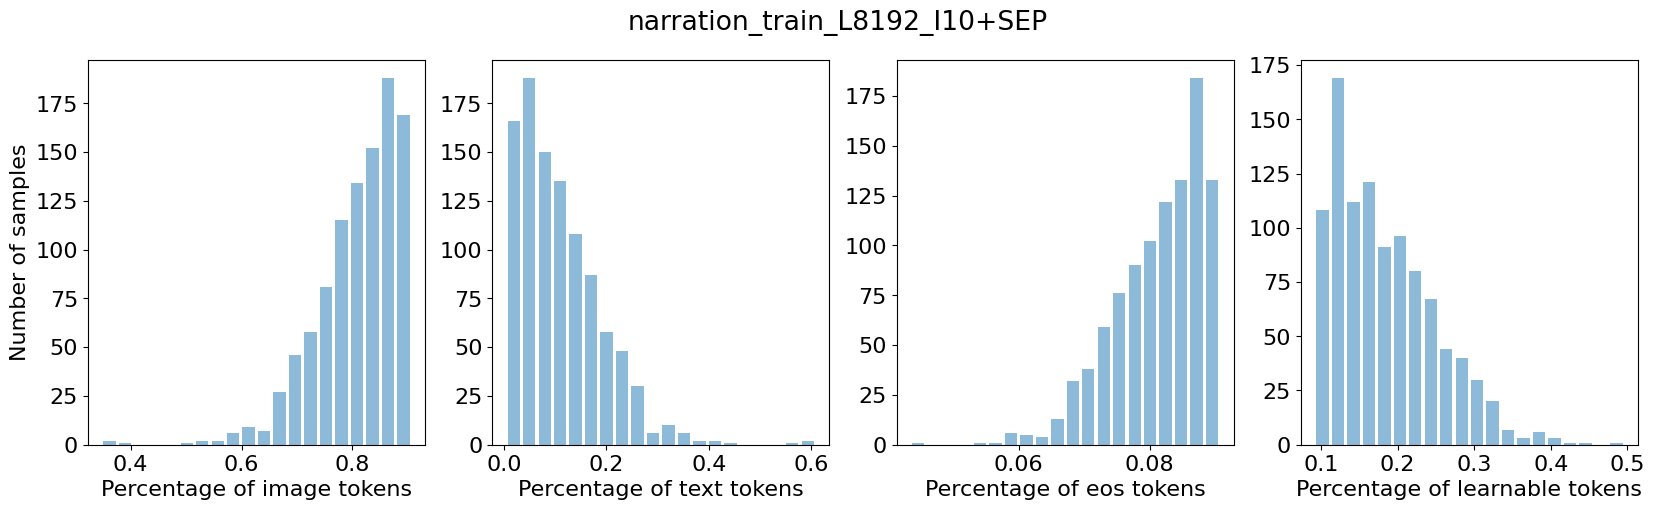

In [56]:
# plot histogram
import numpy as np
import matplotlib.pyplot as plt
# global fontize
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].hist(ratio_img_tokens, bins=20, alpha=0.5, rwidth=0.8)
axs[0].set_xlabel("Percentage of image tokens")
axs[0].set_ylabel("Number of samples")
axs[1].hist(ratio_txt_tokens, bins=20, alpha=0.5, rwidth=0.8)
axs[1].set_xlabel("Percentage of text tokens")
# axs[1].set_ylabel("Number of samples")
axs[2].hist(ratio_eos_tokens, bins=20, alpha=0.5, rwidth=0.8)
axs[2].set_xlabel("Percentage of eos tokens")
# axs[2].set_ylabel("Number of samples")
axs[3].hist(ratio_learnable_tokens, bins=20, alpha=0.5, rwidth=0.8)
axs[3].set_xlabel("Percentage of learnable tokens")
# axs[3].set_ylabel("Number of samples")

#overall title
fig.suptitle(df.replace(".jsonl", ""))


# print
print("Num total tokens:", all_num_tokens)
print("Num img tokens:", all_num_img_tokens)
print("Num txt tokens:", all_num_txt_tokens)
print("Num eos tokens:", all_num_eos_tokens)
print("Num learnable tokens:", all_num_learnable_tokens)

Num total tokens: 1684337
Num img tokens: 514751
Num txt tokens: 653835
Num eos tokens: 515751
Num learnable tokens: 1152380


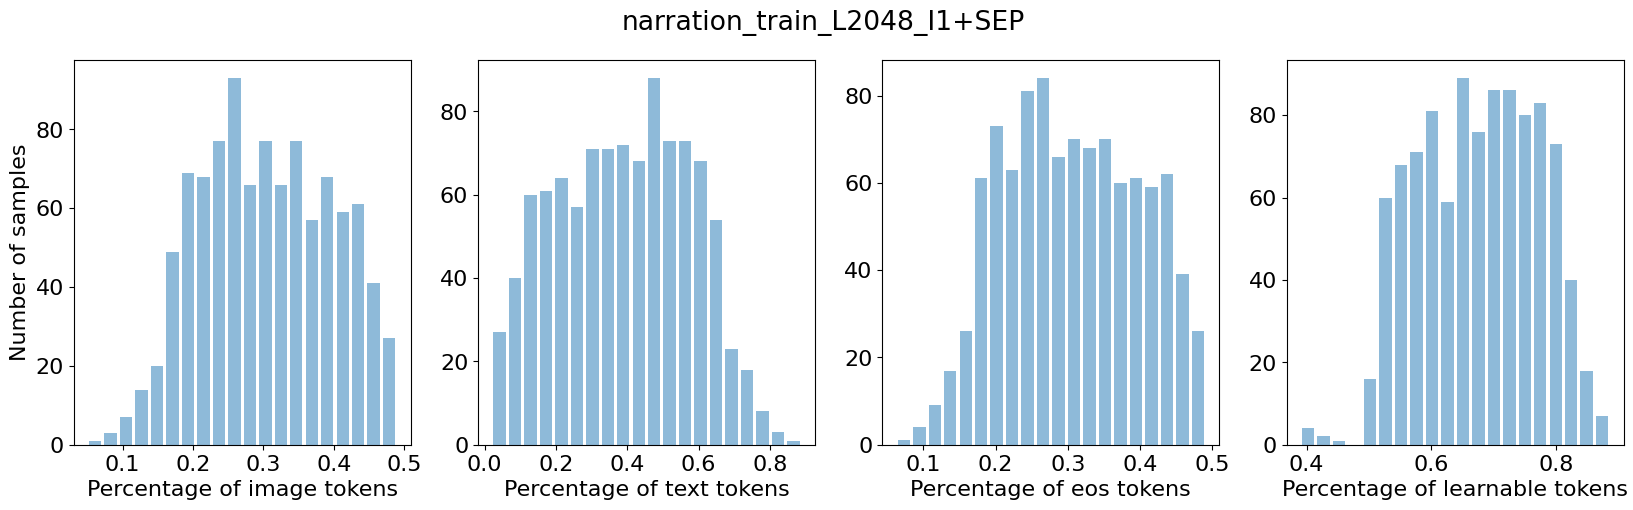

In [50]:
# plot histogram
import numpy as np
import matplotlib.pyplot as plt
# global fontize
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].hist(ratio_img_tokens, bins=20, alpha=0.5, rwidth=0.8)
axs[0].set_xlabel("Percentage of image tokens")
axs[0].set_ylabel("Number of samples")
axs[1].hist(ratio_txt_tokens, bins=20, alpha=0.5, rwidth=0.8)
axs[1].set_xlabel("Percentage of text tokens")
# axs[1].set_ylabel("Number of samples")
axs[2].hist(ratio_eos_tokens, bins=20, alpha=0.5, rwidth=0.8)
axs[2].set_xlabel("Percentage of eos tokens")
# axs[2].set_ylabel("Number of samples")
axs[3].hist(ratio_learnable_tokens, bins=20, alpha=0.5, rwidth=0.8)
axs[3].set_xlabel("Percentage of learnable tokens")
# axs[3].set_ylabel("Number of samples")

#overall title
fig.suptitle(df.replace(".jsonl", ""))


# print
print("Num total tokens:", all_num_tokens)
print("Num img tokens:", all_num_img_tokens)
print("Num txt tokens:", all_num_txt_tokens)
print("Num eos tokens:", all_num_eos_tokens)
print("Num learnable tokens:", all_num_learnable_tokens)

Text(0, 0.5, 'Number of samples')

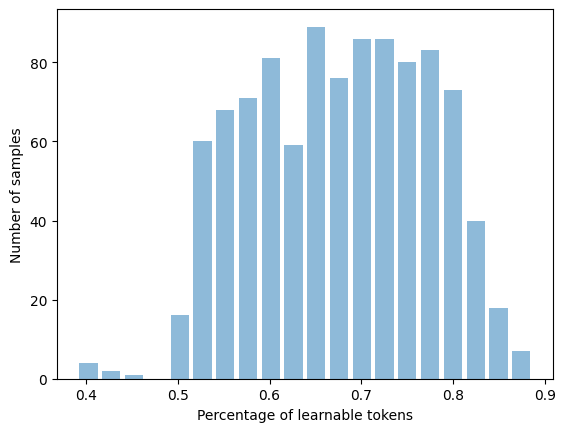

In [32]:
# plot histogram
import numpy as np
import matplotlib.pyplot as plt

plt.hist(ratio_learnable_tokens, bins=20, alpha=0.5, rwidth=0.8)
plt.xlabel("Percentage of learnable tokens", fontsize=14)
plt.ylabel("Number of samples", fontsize=14)
# xtick
# plt.xticks(np.arange(0, 1.1, 0.1))

# plt.hist(ratio_img_tokens, bins=20, alpha=0.5, label='img')
# plt.xlabel("Percentage of image tokens")
# plt.ylabel("Number of samples")

In [58]:
ann.keys()

dict_keys(['video_id', 'narr_annotator_id', 'original_fps', 'sample_fps', 'frames_file', 'conversation', 'raw_narrations', 'video_meta'])

In [60]:
import os
import json
import glob
from tqdm import tqdm
from collections import Counter


neg = 0
pos = 0
percentages = Counter()
processed_data_dir = "/fsx_0/user/imzyc/processed_data/ego4d"
for ann_file in tqdm(glob.glob(os.path.join(processed_data_dir, "annotations", "*.json"))):
    with open(ann_file, "r") as f:
        ann = json.load(f)
    
    this_pos = 0
    this_neg = 0
    for n in ann["conversation"]:
        if n["role"] == "assistant":
            this_pos += 1
        elif n["role"] == "frames":
            this_neg += (n["end"] - n["start"] -1)
    
    narrated_frame_percentage = this_pos / (this_pos + this_neg)
    percentages[int(narrated_frame_percentage * 100)] += 1

    pos += this_pos
    neg += this_neg


print(pos, neg, pos / (pos + neg))

  0%|          | 0/17186 [00:00<?, ?it/s]

100%|██████████| 17186/17186 [00:51<00:00, 333.65it/s]

3660248 44662202 0.07574632494834181


Text(0, 0.5, 'Number of videos')

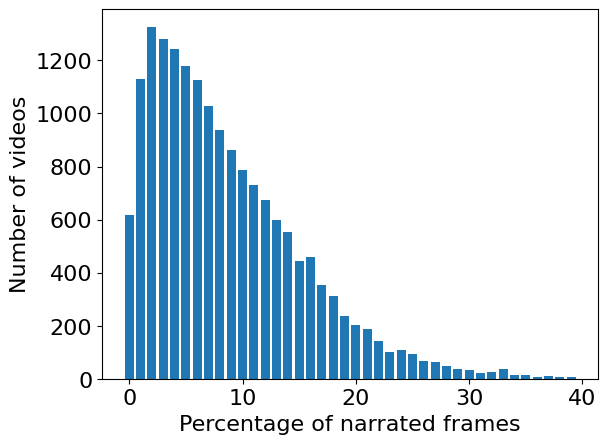

In [66]:
# plot histogram
import matplotlib.pyplot as plt

percentages_trun40 = {k: v for k, v in percentages.items() if k < 40}
plt.bar(percentages_trun40.keys(), percentages_trun40.values())
plt.xlabel("Percentage of narrated frames")
plt.ylabel("Number of videos")

Text(0, 0.5, 'Number of videos')

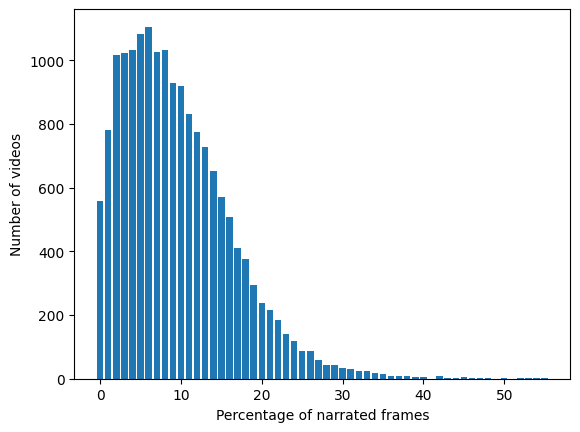

In [11]:
# plot histogram
import matplotlib.pyplot as plt

plt.bar(percentages.keys(), percentages.values())
plt.xlabel("Percentage of narrated frames")
plt.ylabel("Number of videos")

In [2]:
import os
import json
import glob

processed_data_dir = "/fsx_0/user/imzyc/processed_data/ego4d"
video_ids = ["4cac8e34-cac1-408c-85a0-b42bd3e550d7"]

video

for vid in video_ids:
    pass_no = 1
    ann_file = os.path.join(processed_data_dir, "annotations", f"{vid}_PASS{pass_no}.json")
    with open(ann_file, "r") as f:
        ann = json.load(f)
    
    frame_dir = os.path.join(processed_data_dir, "frames", vid)
    assert os.path.exists(frame_dir), f"Frame directory {frame_dir} does not exist"

In [5]:
def get_positive_narration_percetage(ann):
    pos_anns = [n for n in ann["processed_narrations"] if n["assistant"]]
    return len(pos_anns) / len(ann["processed_narrations"])

get_positive_narration_percetage(ann)

0.10843373493975904